## Homework 1


Tanya Balaraju

Professor Matthew Stone

CS 533  

Due March 19


*Modification of classifier-patterns.ipynb*

In this notebook, the TFIDF representation of the 20 Newsgroups dataset will be used to hypothesize about the classification of two newsgroups in the dataset. The hypothesis will then be evaluated using the classification methods from the classifier-patterns notebook.

**Important Notes: **

- All code in this notebook is in Python 3. Modifications will need to be made in order to run the notebook using Python 2. 
- The Experiment class has been modified; xval() now returns the average accuracy.
- All values mentioned in the "text" sections of the notebook are returned from the first iteration of the experiments. Running this notebook again may lead to slight variations in the accuracies, because the experiments are being rerun. 
- The format of the filesystem used in this experiment is as follows:
    - news/20news-bydate-train/pos_NUMBER is the directory containing the "positive classification" training set for newsgroup NUMBER.
    - news/20news-bydate-train/neg_NUMBER is the directory containing the "positive classification" training set for newsgroup NUMBER (i.e., files from all newsgroups other than newsgroup NUMBER).
    - The above formatting applies to the testing set as well. 
    - To run this notebook, the following subdirectories will be necessary in both 20news-bydate-train/ and 20news-bydate-test/: pos_15, neg_15, pos_17, neg_17, pos_0, neg_0, and pos_6, and neg_6. *The correctly-formatted directory has been included in the file news.tgz.*

## 0. General Setup

The code below remains consistent throughout all of the experiments (modified from classifier-patterns).

In [2]:
from __future__ import print_function
import os
import nltk
#nltk.download()
import re
import itertools
import vocabulary
import newsreader
import numpy as np
import scipy
import sklearn
import random
import warnings
warnings.filterwarnings('ignore')
from numpy import add, array, dot
from numpy.linalg import norm
from scipy.sparse import csr_matrix
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
try:
    import cPickle as pickle
except:
    import pickle

In [35]:
vocab_file, vocab_file_type = "reviews-vocab.pkl", "pickle"

embedding_file, embedding_dimensions, embedding_cache = \
    "glove.6B.50d.txt", 50, "news-embedding.npz"

all_data, train_dir, dev_dir, test_dir = \
    "news/", "news/20news-bydate-train/", None, "news/20news-bydate-test/"

has_bad_metadata = True
made_vocabulary = True

if made_vocabulary :
    v = vocabulary.Vocabulary.load(vocab_file, file_type=vocab_file_type)
else: 
    tokens = newsreader.all_textfile_tokens(all_data, strip_metadata=has_bad_metadata)                                            
    v = vocabulary.Vocabulary.from_iterable(tokens, file_type=vocab_file_type)
    v.save(vocab_file)
v.stop_growth()

made_embedding = True
if made_embedding :
    e = newsreader.load_sparse_csr(embedding_cache)
else: 
    e = newsreader.build_sparse_embedding(v, embedding_file, embedding_dimensions)
    newsreader.save_sparse_csr(embedding_cache, e)

targets = []
def selected(name) :
    if not targets:
        return True
    if any(t.startswith(name) for t in targets) :
        return True
    return False

def use_default_features(vocab) :
    return lambda data: vocab

def count_features(features, gen_tokens) :
    for t in gen_tokens :
        r = features.add(t)
        if r :
            yield r 

def make_boolean_features(feature_counter) :
    def collect_features(features, gen_tokens) :
        seen = set()
        for f in feature_counter(features, gen_tokens) :
            seen.add(f)
        for f in seen :
            yield f
    return collect_features

class Experiment(object) :
    '''Organize the process of getting data, building a classifier,
    and exploring new representations'''
    
    def __init__(self, data, comment, classifier, cdesc) :
        'set up the problem of learning a classifier from a data manager'
        self.data = data
        self.comment = comment
        self.classifier = classifier
        self.cdesc = cdesc
        self.initialized = False
        
    def initialize(self) :
        'materialize the training data, dev data and test data as matrices'
        if not self.initialized :
            self.train_X, self.train_y = self.data.training_data()
            self.dev_X, self.dev_y = self.data.dev_data()
            self.test_X, self.test_y = self.data.test_data()
            self.initialized = True
        
    def fit_and_validate(self, report=True) :
        'train the classifier and assess predictions on dev data'
        if not self.initialized :
            self.initialize()
        self.classifier.fit(self.train_X, self.train_y)
        self.dev_predictions = self.classifier.predict(self.dev_X)
        self.accuracy = sklearn.metrics.accuracy_score(self.dev_y, self.dev_predictions)
        if report :
            print("{}\nclassified by {}\naccuracy {}".format(self.comment, self.cdesc, self.accuracy))
            
    def xval(self, folds=20, report=True) :
        #print("Running xval")
        accuracies = []
        for i in range(folds) :
            self.fit_and_validate(report=False)
            accuracies.append(self.accuracy)
        if report :
            msg = "{}\nclassified by {}\naverage accuracy {} (std {})"
            print(msg.format(self.comment, self.cdesc, 
                             sum(accuracies)/folds,
                             np.std(accuracies)))
            #print("{},{}".format(accuracies,folds))
            return sum(accuracies)/folds
    
    @classmethod
    def transform(cls, expt, operation, description, classifier, cdesc) :
        'use operation to transform the data from expt and set up new classifier'
        if not expt.initialized :
            expt.initialize()
        result = cls(expt.data, expt.comment + '\n' + description, classifier, cdesc)
        result.train_X, result.train_y = operation(expt.train_X, expt.train_y, 'train')
        result.dev_X, result.dev_y = operation(expt.dev_X, expt.dev_y, 'dev')
        result.test_X, result.test_y = operation(expt.test_X, expt.test_y, 'test')
        result.initialized = True
        return result

def wang_manning_weights(expt) :
    Xyes = expt.train_X[expt.train_y ==1, :]
    Xno = expt.train_X[expt.train_y != 1, :] 
    yesrates = np.log((Xyes.getnnz(axis=0) + 1.) / Xyes.shape[1])
    norates = np.log((Xno.getnnz(axis=0) + 1.) / Xno.shape[1])
    W = scipy.sparse.diags(yesrates - norates, 0)
    return lambda X, y, c: (X.dot(W), y)

More function definitions:

In [3]:
def idf_weights(expt) :
    idf = np.log((expt.train_X.shape[1] + 1.) / (expt.train_X.getnnz(axis=0) + 1.))
    W = scipy.sparse.diags(idf, 0)
    return lambda X, y, c: (X.dot(W), y)

def add_embeddings(expt, embeddings, scale=True, stack=True) :
    extra_features = expt.train_X.shape[1] - embeddings.shape[0]
    if extra_features > 0 :
        Z = scipy.sparse.csr_matrix((extra_features, embeddings.shape[1]))
        W = scipy.sparse.vstack([embeddings, Z])
    else: 
        W = embeddings
    if scale :
        scaler = StandardScaler(with_mean=False)
        scaler.fit(expt.train_X.dot(W))
    def operation(X, y, s) :
        if scale:
            new_features = scaler.transform(X.dot(W))
        else :
            new_features = X.dot(W)
        if stack :
            all_features = scipy.sparse.hstack([X, new_features]).tocsr()
        else :
            all_features = new_features
        return (all_features, y)
    return operation

def dimensionality_reduction(expt, dimensions) :
    _, _, wrt = scipy.sparse.linalg.svds(expt.train_X, k=dimensions, 
                                         return_singular_vectors='vh')
    return add_embeddings(expt, np.transpose(wrt), stack=False)

def use_bigram_features(data) :
    f = vocabulary.Vocabulary.load(vocab_file, file_type=vocab_file_type)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    word_fd = nltk.FreqDist(data.all_train_tokens())
    bigram_fd = nltk.FreqDist(nltk.bigrams(data.all_train_tokens()))
    finder = nltk.collocations.BigramCollocationFinder(word_fd, bigram_fd)
    finder.apply_freq_filter(5)
    collocations = filter(lambda g: g[1] > 0, finder.score_ngrams(bigram_measures.pmi))
    for (w1, w2), _ in collocations:
        f.add(w1 + " " + w2)
    f.stop_growth()
    return f

def count_bigram_features(features, gen_tokens) :
    prev = None
    for t in gen_tokens :
        r = features.add(t)
        if r :
            yield r
            if prev :
                r = features.add(prev + " " + t)
                if r : 
                    yield r
            prev = t
            
def limit_training(percent) :
    def operation(X, y, s) :
        if s != 'train' :
            return (X, y)
        data_to_take = int(X.shape[0] * percent)
        indices = np.random.choice(X.shape[0], 
                                      size=data_to_take,
                                      replace=False)
        return (X[indices,:], y[indices])
    return operation

## 1. Pair Comparisons

### 1.1: Similar Newsgroups 

The first assumption made is that the newsgroups "Religion: Miscellaneous" (class 19) and "Religion: Christian" (class 15) are probably fairly similar. Running the experiments on these groups requires some setup: 

In [4]:
#files in class 15
class15_pos = "pos_15"
#files in class 19
class15_neg = "neg_15"

count15_data = newsreader.DataManager(train_dir + class15_pos,
                                       train_dir + class15_neg,
                                       test_dir + class15_pos,
                                       test_dir + class15_neg,
                                       use_default_features(v),
                                       count_features,
                                       dev_dir + class15_pos if dev_dir else None,
                                       dev_dir + class15_neg if dev_dir else None,
                                       strip_metadata=has_bad_metadata)


boolean_data_15 = newsreader.DataManager(train_dir + class15_pos,
                                         train_dir + class15_neg,
                                         test_dir + class15_pos,
                                         test_dir + class15_neg,
                                         use_default_features(v),
                                         make_boolean_features(count_features),
                                         dev_dir + class15_pos if dev_dir else None,
                                         dev_dir + class15_neg if dev_dir else None,
                                         strip_metadata=has_bad_metadata)

count15_data.initialize(build_cache=True)
boolean_data_15.initialize(build_cache=True)

Now, we run the first experiment: 

In [5]:
if selected("expt_10_class15"):
    expt_10_c15 = Experiment(count15_data,
                       "{}: {} vs {}, using word count features".format(all_data, class15_pos, class15_neg),
                       sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                       "logistic regression")
    expt_10_c15.initialize()
    expt_10_c15.xval()

Running xval
news/: pos_15 vs neg_15, using word count features
classified by logistic regression
average accuracy 0.6944444444444445 (std 0.011790522757503785)
[0.6767676767676768, 0.71212121212121215, 0.71717171717171713, 0.6767676767676768, 0.70707070707070707, 0.6767676767676768, 0.69191919191919193, 0.69696969696969702, 0.70202020202020199, 0.68686868686868685, 0.68686868686868685, 0.70202020202020199, 0.68181818181818177, 0.70202020202020199, 0.70707070707070707, 0.69191919191919193, 0.69696969696969702, 0.70202020202020199, 0.68181818181818177, 0.69191919191919193],20


At about 70%, the accuracy of the classification using word count features appears to be fairly low, although this was a high-performing method in the original classifier-patterns notebook. This is unsurprising; the two classes are plausibly similar enough to lead to such an outcome. 

Now, we test further: 

In [6]:
if selected("expt_11_class15") :
    expt_11_c15 = Experiment(boolean_data_15,
                         "{}: {} vs {}, using word presence/absence features".format(all_data, class15_pos, class15_neg),
                         sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                         "logistic regression")
    expt_11_c15.initialize()
    expt_11_c15.xval()

Running xval
news/: pos_15 vs neg_15, using word presence/absence features
classified by logistic regression
average accuracy 0.7161616161616162 (std 0.016334304675551747)
[0.75252525252525249, 0.72222222222222221, 0.71717171717171713, 0.70202020202020199, 0.68181818181818177, 0.71717171717171713, 0.69696969696969702, 0.72727272727272729, 0.72222222222222221, 0.71212121212121215, 0.74242424242424243, 0.72727272727272729, 0.70707070707070707, 0.69696969696969702, 0.72727272727272729, 0.70202020202020199, 0.70707070707070707, 0.72222222222222221, 0.70707070707070707, 0.73232323232323238],20


Although slightly better than the word-count classification, the average accuracy in this case is still fairly low, at 71%. 

We continue with the remaining experiments from classifier-patterns:

In [7]:
if selected("expt_11_20_c15") :
    expt_11_20_c15 = Experiment.transform(expt_11_c15,
                             wang_manning_weights(expt_11_c15),
                             "features weighted by evidence they give of class",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_11_20_c15.xval()

Running xval
news/: pos_15 vs neg_15, using word presence/absence features
features weighted by evidence they give of class
classified by logistic regression
average accuracy 0.7414141414141414 (std 0.017466279258374323)
[0.72727272727272729, 0.75252525252525249, 0.74242424242424243, 0.70202020202020199, 0.74747474747474751, 0.74242424242424243, 0.73737373737373735, 0.76262626262626265, 0.75252525252525249, 0.73232323232323238, 0.73232323232323238, 0.73737373737373735, 0.70707070707070707, 0.74242424242424243, 0.75252525252525249, 0.77777777777777779, 0.75252525252525249, 0.76262626262626265, 0.73737373737373735, 0.72727272727272729],20


We see an improvement in accuracy after introducing Wang-Manning weights, bringing the accuracy to 75%.

In [8]:
if selected("expt_10_20_c15") :
    expt_10_20_c15 = Experiment.transform(expt_10_c15,
                             idf_weights(expt_10_c15),
                             "features weighted by inverse document frequency",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_10_20_c15.xval()

Running xval
news/: pos_15 vs neg_15, using word count features
features weighted by inverse document frequency
classified by logistic regression
average accuracy 0.6941919191919192 (std 0.014238035716172182)
[0.70202020202020199, 0.68686868686868685, 0.69696969696969702, 0.72727272727272729, 0.70202020202020199, 0.69191919191919193, 0.6767676767676768, 0.68181818181818177, 0.69191919191919193, 0.69191919191919193, 0.69696969696969702, 0.67171717171717171, 0.71212121212121215, 0.68686868686868685, 0.66666666666666663, 0.70202020202020199, 0.71212121212121215, 0.68181818181818177, 0.70202020202020199, 0.70202020202020199],20


Using Inverse Document Frequency (IDF) for feature weighting does not seem to improve the original accuracy of Experiment 10; it remains around 70%.

Now, we use word embeddings and LSA transformations on experiments 10 and 11: 

In [9]:
if selected("expt_10_211_c15") :
    expt_10_211_c15 = Experiment.transform(expt_10_c15,
                             add_embeddings(expt_10_c15, e),
                             "enriched via word embeddings",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_10_211_c15.xval()

if selected ("expt_10_212_c15") :
    expt_10_212_c15 = Experiment.transform(expt_10_c15,
                             dimensionality_reduction(expt_10_c15, 100),
                             "transformed via LSA(100)",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                           "logistic regression")
    expt_10_212_c15.xval()
    
if selected("expt_11_211_") :
    expt_11_211_c15 = Experiment.transform(expt_11_c15,
                             add_embeddings(expt_11_c15, e),
                             "enriched via word embeddings",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_211_c15.xval()

if selected("expt_11_20_211_c15") :
    expt_11_20_211_c15 = Experiment.transform(expt_11_20_c15,
                             add_embeddings(expt_11_20_c15, e),
                             "enriched via word embeddings",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_20_211_c15.xval()



Running xval
news/: pos_15 vs neg_15, using word count features
enriched via word embeddings
classified by logistic regression
average accuracy 0.7012626262626263 (std 0.014220109318485944)
[0.70707070707070707, 0.72727272727272729, 0.71717171717171713, 0.70202020202020199, 0.68686868686868685, 0.70202020202020199, 0.70707070707070707, 0.71212121212121215, 0.69696969696969702, 0.69696969696969702, 0.71212121212121215, 0.71717171717171713, 0.70202020202020199, 0.71717171717171713, 0.69191919191919193, 0.68686868686868685, 0.70202020202020199, 0.67171717171717171, 0.67171717171717171, 0.69696969696969702],20
Running xval
news/: pos_15 vs neg_15, using word count features
transformed via LSA(100)
classified by logistic regression
average accuracy 0.6527777777777777 (std 0.026430842393878332)
[0.66161616161616166, 0.6767676767676768, 0.63131313131313127, 0.63636363636363635, 0.57070707070707072, 0.66161616161616166, 0.64646464646464652, 0.65151515151515149, 0.63131313131313127, 0.656565656

Experiment 10 is not significantly improved by the use of word embeddings, and it is worsened by the LSA transformation (accuracy falls to 65%). Experiment 11 is also not significantly improved with word embeddings, but weighting the features by the evidence they give of their class increases the base accuracy to 74%.

In [10]:
bigram_data = newsreader.DataManager(train_dir + class15_pos,
                                       train_dir + class15_neg,
                                       test_dir + class15_pos,
                                       test_dir + class15_neg,
                                       use_bigram_features,
                                       make_boolean_features(count_bigram_features),
                                       dev_dir + class15_pos if dev_dir else None,
                                       dev_dir + class15_neg if dev_dir else None,
                                       strip_metadata=has_bad_metadata)

bigram_data.initialize(build_cache=True)

if selected("expt_22_c15") :
    expt_22_c15 = Experiment(bigram_data,
                   "{}: {} vs {}, using word and bigram presence/absence features".format(all_data, class15_pos, class15_neg),
                   sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                   "logistic regression")
    expt_22_c15.initialize()
    expt_22_c15.xval()

print ('\n')
if selected("expt_22_220_c15") :
    expt_22_220_c15 = Experiment.transform(expt_22_c15,
                             wang_manning_weights(expt_22_c15),
                             "features weighted by evidence they give of class",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_22_220_c15.initialize()
    expt_22_220_c15.xval()



Running xval
news/: pos_15 vs neg_15, using word and bigram presence/absence features
classified by logistic regression
average accuracy 0.7045454545454546 (std 0.018314610469160362)
[0.68181818181818177, 0.71212121212121215, 0.71212121212121215, 0.67171717171717171, 0.71212121212121215, 0.73232323232323238, 0.72222222222222221, 0.69191919191919193, 0.73737373737373735, 0.71717171717171713, 0.68181818181818177, 0.69696969696969702, 0.70707070707070707, 0.71717171717171713, 0.68181818181818177, 0.69696969696969702, 0.69696969696969702, 0.68181818181818177, 0.71212121212121215, 0.72727272727272729],20


Running xval
news/: pos_15 vs neg_15, using word and bigram presence/absence features
features weighted by evidence they give of class
classified by logistic regression
average accuracy 0.7510101010101009 (std 0.020829889522526533)
[0.78787878787878785, 0.75252525252525249, 0.72222222222222221, 0.75252525252525249, 0.77272727272727271, 0.74242424242424243, 0.76767676767676762, 0.732323232

Although the use of word and bigram presence/absence features does not improve the experiment, adding the weighting of features by the evidence they give of their class increases the accuracy to around 75%.

Finally, we limit the training data and observe the changes: 

In [11]:
if selected("expt_11_231_c15") :
    expt_11_231_c15 = Experiment.transform(expt_11_c15,
                             limit_training(0.1),
                             "considering 10% training data",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_231_c15.xval()

print ('\n')

if selected("expt_11_211_232_c15") :
    expt_11_231_232_c15 = Experiment.transform(expt_11_211_c15,
                             limit_training(0.1),
                             "considering 10% training data",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_231_232_c15.xval()

print ('\n')

if selected("expt_11_20_233_c15") :
    expt_11_20_232_c15 = Experiment.transform(expt_11_20_c15,
                             limit_training(0.1),
                             "considering 10% training data",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_20_232_c15.xval()
    
print ('\n')

if selected("expt_11_20_211_234_c15") :
    expt_11_20_211_232_c15 = Experiment.transform(expt_11_20_211_c15,
                             limit_training(0.1),
                             "considering 10% training data",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_20_211_232_c15.xval()

print ('\n')

Running xval
news/: pos_15 vs neg_15, using word presence/absence features
considering 10% training data
classified by logistic regression
average accuracy 0.5979797979797981 (std 0.029118253142221363)
[0.57070707070707072, 0.58080808080808077, 0.57070707070707072, 0.53535353535353536, 0.64141414141414144, 0.58080808080808077, 0.59595959595959591, 0.61111111111111116, 0.64141414141414144, 0.63131313131313127, 0.59090909090909094, 0.60101010101010099, 0.64646464646464652, 0.61616161616161613, 0.58585858585858586, 0.62121212121212122, 0.61111111111111116, 0.55555555555555558, 0.59595959595959591, 0.5757575757575758],20


Running xval
news/: pos_15 vs neg_15, using word presence/absence features
enriched via word embeddings
considering 10% training data
classified by logistic regression
average accuracy 0.620959595959596 (std 0.03115285635598802)
[0.58080808080808077, 0.57070707070707072, 0.6262626262626263, 0.64646464646464652, 0.64141414141414144, 0.65656565656565657, 0.6515151515151514

Unsurprisingly, the accuracy here is considerably lower. However, the final experiment is only 2 percentage points away from the original accuracy of experiment 10, indicating that the feature weighting and word embeddings did help with the reduced accuracy from the smaller training set.

### 1.2: Different Newsgroups

Now, we test two newsgroups that appear to be different: Newsgroup 17 (Politics: MidEast) and Newsgroup 10 (Sports: Hockey), using the same process as above:

In [12]:
#files in class 17
class17_pos = "pos_17"
#files in class 10
class17_neg = "neg_17"

count17_data = newsreader.DataManager(train_dir + class17_pos,
                                       train_dir + class17_neg,
                                       test_dir + class17_pos,
                                       test_dir + class17_neg,
                                       use_default_features(v),
                                       count_features,
                                       dev_dir + class17_pos if dev_dir else None,
                                       dev_dir + class17_neg if dev_dir else None,
                                       strip_metadata=has_bad_metadata)


boolean_data_17 = newsreader.DataManager(train_dir + class17_pos,
                                         train_dir + class17_neg,
                                         test_dir + class17_pos,
                                         test_dir + class17_neg,
                                         use_default_features(v),
                                         make_boolean_features(count_features),
                                         dev_dir + class17_pos if dev_dir else None,
                                         dev_dir + class17_neg if dev_dir else None,
                                         strip_metadata=has_bad_metadata)

count17_data.initialize(build_cache=True)
boolean_data_17.initialize(build_cache=True)

Experiments 10 and 11 are as follows:

In [13]:
if selected("expt_10_class17"):
    expt_10_c17 = Experiment(count17_data,
                       "{}: {} vs {}, using word count features".format(all_data, class17_pos, class17_neg),
                       sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                       "logistic regression")
    expt_10_c17.initialize()
    expt_10_c17.xval()

print ('\n')

if selected("expt_11_class17") :
    expt_11_c17 = Experiment(boolean_data_17,
                         "{}: {} vs {}, using word presence/absence features".format(all_data, class17_pos, class17_neg),
                         sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                         "logistic regression")
    expt_11_c17.initialize()
    expt_11_c17.xval()

Running xval
news/: pos_17 vs neg_17, using word count features
classified by logistic regression
average accuracy 0.9226063829787234 (std 0.01029705355457764)
[0.92553191489361697, 0.93617021276595747, 0.92553191489361697, 0.92553191489361697, 0.91489361702127658, 0.92021276595744683, 0.92553191489361697, 0.92553191489361697, 0.93085106382978722, 0.91489361702127658, 0.93085106382978722, 0.92021276595744683, 0.93617021276595747, 0.92553191489361697, 0.90957446808510634, 0.90957446808510634, 0.90957446808510634, 0.89893617021276595, 0.94148936170212771, 0.92553191489361697],20


Running xval
news/: pos_17 vs neg_17, using word presence/absence features
classified by logistic regression
average accuracy 0.9284574468085107 (std 0.013610682533961695)
[0.90957446808510634, 0.93617021276595747, 0.94148936170212771, 0.9042553191489362, 0.93617021276595747, 0.93085106382978722, 0.93617021276595747, 0.93085106382978722, 0.94680851063829785, 0.92553191489361697, 0.9521276595744681, 0.9202127659

It is immediately noticeable that the classification is much more successful with Newsgroups 17 and 10 (92-93% success rate for both word count and word presence/absence features) than with Newsgroups 15 and 19, because 17 and 10 are much more distinct.

We continue these experiments to observe continued success:

In [14]:
if selected("expt_11_20_c17") :
    expt_11_20_c17 = Experiment.transform(expt_11_c17,
                             wang_manning_weights(expt_11_c17),
                             "features weighted by evidence they give of class",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_11_20_c17.xval()

Running xval
news/: pos_17 vs neg_17, using word presence/absence features
features weighted by evidence they give of class
classified by logistic regression
average accuracy 0.9545212765957449 (std 0.013506344601696401)
[0.94680851063829785, 0.9521276595744681, 0.9521276595744681, 0.96276595744680848, 0.94148936170212771, 0.97872340425531912, 0.96808510638297873, 0.96276595744680848, 0.93617021276595747, 0.94148936170212771, 0.97872340425531912, 0.92553191489361697, 0.95744680851063835, 0.9521276595744681, 0.96276595744680848, 0.9521276595744681, 0.9521276595744681, 0.94680851063829785, 0.94680851063829785, 0.97340425531914898],20


In [15]:
if selected("expt_10_20_c17") :
    expt_10_20_c17 = Experiment.transform(expt_10_c17,
                             idf_weights(expt_10_c17),
                             "features weighted by inverse document frequency",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_10_20_c17.xval()

Running xval
news/: pos_17 vs neg_17, using word count features
features weighted by inverse document frequency
classified by logistic regression
average accuracy 0.9140957446808509 (std 0.011807432383203784)
[0.90957446808510634, 0.92021276595744683, 0.8936170212765957, 0.89893617021276595, 0.93085106382978722, 0.9042553191489362, 0.90957446808510634, 0.9042553191489362, 0.92553191489361697, 0.89893617021276595, 0.91489361702127658, 0.93085106382978722, 0.93085106382978722, 0.92021276595744683, 0.91489361702127658, 0.8936170212765957, 0.92553191489361697, 0.92021276595744683, 0.91489361702127658, 0.92021276595744683],20


The accuracy of the experiment using IDF weighting is slightly lower (91.5%), but accuracy using Wang-Manning weights increases to 95%. Perhaps inverse document frequency is not as informative as the words' relevance to their classification. This makes sense--with two classes so wildly different from each other, the words within each document should be very useful indicators of the document's newsgroup.

Now, we introduce word embeddings and LSA transformations.

In [16]:
if selected("expt_10_211_c17") :
    expt_10_211_c17 = Experiment.transform(expt_10_c17,
                             add_embeddings(expt_10_c17, e),
                             "enriched via word embeddings",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_10_211_c17.xval()

print ('\n')

if selected ("expt_10_212_c17") :
    expt_10_212_c17 = Experiment.transform(expt_10_c17,
                             dimensionality_reduction(expt_10_c17, 100),
                             "transformed via LSA(100)",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                           "logistic regression")
    expt_10_212_c17.xval()

print ('\n')


if selected("expt_11_211_c17") :
    expt_11_211_c17 = Experiment.transform(expt_11_c17,
                             add_embeddings(expt_11_c17, e),
                             "enriched via word embeddings",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_211_c17.xval()
    
print ('\n')


if selected("expt_11_20_211_c17") :
    expt_11_20_211_c17 = Experiment.transform(expt_11_20_c17,
                             add_embeddings(expt_11_20_c17, e),
                             "enriched via word embeddings",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_20_211_c17.xval()



Running xval
news/: pos_17 vs neg_17, using word count features
enriched via word embeddings
classified by logistic regression
average accuracy 0.9223404255319148 (std 0.008308776250964534)
[0.90957446808510634, 0.93085106382978722, 0.92553191489361697, 0.92021276595744683, 0.93085106382978722, 0.90957446808510634, 0.92553191489361697, 0.93617021276595747, 0.91489361702127658, 0.91489361702127658, 0.90957446808510634, 0.93085106382978722, 0.92021276595744683, 0.92021276595744683, 0.92021276595744683, 0.93617021276595747, 0.91489361702127658, 0.92021276595744683, 0.93085106382978722, 0.92553191489361697],20


Running xval
news/: pos_17 vs neg_17, using word count features
transformed via LSA(100)
classified by logistic regression
average accuracy 0.9039893617021276 (std 0.0063995794763382656)
[0.90957446808510634, 0.90957446808510634, 0.9042553191489362, 0.89893617021276595, 0.9042553191489362, 0.90957446808510634, 0.89893617021276595, 0.9042553191489362, 0.89893617021276595, 0.88829787

When using word embeddings with word count features, the accuracy of the experiment remains around 92%; these do not appear to be helpful in classifying documents by their newsgroup with word count features. This is similar to the experiment in 1.1. Also similar to 1.1, the experiment's accuracy is greatly reduced by LSA. Interestingly, however, 1.1 and 1.2 have similar accuracies when LSA is used (around 65%), despite the pairs of newsgroups being different in nature. This could be simply due to the fact that LSA reduces detail enough for both experiments to be equivalent to something slightly better than a blind guess (50%). 

Unsurprisingly, the base accuracy of the experiment using word presence/absence features is improved by the use of word embeddings and word presence/absence features, and by the addition of Wang-Manning weights to this scheme (94% and 96%, respectively). 

We now introduce bigram data: 

In [17]:
bigram_data = newsreader.DataManager(train_dir + class17_pos,
                                       train_dir + class17_neg,
                                       test_dir + class17_pos,
                                       test_dir + class17_neg,
                                       use_bigram_features,
                                       make_boolean_features(count_bigram_features),
                                       dev_dir + class17_pos if dev_dir else None,
                                       dev_dir + class17_neg if dev_dir else None,
                                       strip_metadata=has_bad_metadata)

bigram_data.initialize(build_cache=True)

if selected("expt_22_c17") :
    expt_22_c17 = Experiment(bigram_data,
                   "{}: {} vs {}, using word and bigram presence/absence features".format(all_data, class17_pos, class17_neg),
                   sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                   "logistic regression")
    expt_22_c17.initialize()
    expt_22_c17.xval()

print ('\n')

if selected("expt_22_220_c17") :
    expt_22_220_c17 = Experiment.transform(expt_22_c17,
                             wang_manning_weights(expt_22_c17),
                             "features weighted by evidence they give of class",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_22_220_c17.initialize()
    expt_22_220_c17.xval()

print ('\n')


if selected("expt_22_221_") :
    expt_22_221_c17 = Experiment.transform(expt_22_c17,
                             add_embeddings(expt_22_c17, e),
                             "with word embedding features added",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_22_221_c17.xval()

print ('\n')


if selected("expt_22_220_221_c17") :
    expt_22_220_221_c17 = Experiment.transform(expt_22_220_c17,
                             add_embeddings(expt_22_220_c17, e),
                             "with word embedding features added",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_22_220_221_c17.xval()

print ('\n')



Running xval
news/: pos_17 vs neg_17, using word and bigram presence/absence features
classified by logistic regression
average accuracy 0.9138297872340424 (std 0.013414383205232427)
[0.93085106382978722, 0.88829787234042556, 0.89893617021276595, 0.91489361702127658, 0.92553191489361697, 0.88297872340425532, 0.92553191489361697, 0.89893617021276595, 0.90957446808510634, 0.93085106382978722, 0.92553191489361697, 0.90957446808510634, 0.90957446808510634, 0.93085106382978722, 0.91489361702127658, 0.92553191489361697, 0.90957446808510634, 0.90957446808510634, 0.91489361702127658, 0.92021276595744683],20


Running xval
news/: pos_17 vs neg_17, using word and bigram presence/absence features
features weighted by evidence they give of class
classified by logistic regression
average accuracy 0.9372340425531913 (std 0.009151409858556009)
[0.94148936170212771, 0.93617021276595747, 0.93617021276595747, 0.94148936170212771, 0.93617021276595747, 0.94680851063829785, 0.95744680851063835, 0.930851063

The use of word and bigram presence/absence features lowered the base accuracy slightly (by about 1%), whereas this scheme with added Wang-Manning weights increased the accuracy to about 94%. However, this accuracy is lower than that of the experiment with Wang-Manning weights that did not include bigram presence/absence features. It is possible that the bigrams within these documents are not indicative of the newsgroups.

Similar to before, the addition of word embedding does not seem to improve accuracy significantly; the accuracy stays within 1 percentage point of the similar experiments that did not include bigram presence/absence features.

Finally, we run the experiments using only 10% of the training data:

In [18]:
if selected("expt_11_231_c17") :
    expt_11_231_c17 = Experiment.transform(expt_11_c17,
                             limit_training(0.1),
                             "considering 10% training data",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_231_c17.xval()

print ('\n')

if selected("expt_11_211_232_c17") :
    expt_11_231_232_c17 = Experiment.transform(expt_11_211_c17,
                             limit_training(0.1),
                             "considering 10% training data",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_231_232_c17.xval()

print ('\n')


if selected("expt_11_20_233_c17") :
    expt_11_20_232_c17 = Experiment.transform(expt_11_20_c17,
                             limit_training(0.1),
                             "considering 10% training data",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_20_232_c17.xval()
    
print ('\n')


if selected("expt_11_20_211_234_c17") :
    expt_11_20_211_232_c17 = Experiment.transform(expt_11_20_211_c17,
                             limit_training(0.1),
                             "considering 10% training data",
                            sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_20_211_232_c17.xval()



Running xval
news/: pos_17 vs neg_17, using word presence/absence features
considering 10% training data
classified by logistic regression
average accuracy 0.8678191489361703 (std 0.020619850825746824)
[0.8936170212765957, 0.83510638297872342, 0.8457446808510638, 0.84042553191489366, 0.86170212765957444, 0.87765957446808507, 0.88829787234042556, 0.86170212765957444, 0.8563829787234043, 0.86170212765957444, 0.8457446808510638, 0.86702127659574468, 0.87234042553191493, 0.88829787234042556, 0.90957446808510634, 0.8457446808510638, 0.8936170212765957, 0.85106382978723405, 0.86702127659574468, 0.8936170212765957],20


Running xval
news/: pos_17 vs neg_17, using word presence/absence features
enriched via word embeddings
considering 10% training data
classified by logistic regression
average accuracy 0.9194148936170212 (std 0.01598180764635491)
[0.93617021276595747, 0.94148936170212771, 0.93617021276595747, 0.92553191489361697, 0.8936170212765957, 0.90957446808510634, 0.9042553191489362, 0.9

It appears that using only 10% of the training data in 1.2 is not as detrimental to accuracy as it was in 1.1. This is likely due to the fact that the two newsgroups being compared are distinct enough to provide adequate training for the model with much less data than before. It should be noted that the accuracy does fall slightly when using solely word presence/absence features, word embeddings, or Wang-Manning weights, but it is improved to about 95% with the usage of all three of these methods together.

## 2. Hypothesis

Based on the above exploration, it becomes evident that the pairs of newsgroups that appear more similar are more difficult to classify (as a binary, or positive/negative classification) than those which appear different. This leads to the following hypothesis:

**When compared to ALL other newsgroups, a newsgroup that is similar to many others in the dataset will yield a much lower classification accuracy than a newsgroup that is distinct from many others in the dataset.**

## 3. Experimental Design

First, the cosine similarity between all newsgroups will be calculated and represented in heatmap form, using TFIDF representations of words within documents and newsgroups. Then, this heatmap will be used to select two newsgroups. One of the newsgroups selected ("Newsgroup A") will be similar to the other newsgroups (the cells corresponding to its row in the heatmap matrix will be noticeably lighter) and the other ("Newsgroup B") will be different from the other newsgroups (its rows will consist of visibly darker cells).

Then, the classification accuracy will be measured for each of these newsgroups using various experimental methods. A "positive" classification will indicate that a certain document is part of the newsgroup in question, whereas a "negative" classification will indicate that the document is part of any of the other 19 newsgroups. 

From Part 1 of the experiment, it appears that bigram representations are not a useful way to classify documents. Word embeddings also appear to be ineffective unless combined with Wang-Manning weights and/or word presence/absence features. These experiments, expt_11\_211\_ and expt_11_20\_211\_ , yielded fairly high or baseline-equivalent accuracy in both 1.1 and 1.2. It will be interesting to see whether this is the case in broader comparisons such as the ones in this experiment. Thus, these experiments will be used, along with the basic experiments preceding them. Finally, IDF weights with word count feature representations will also be used to compare the two classifications. The training set will not be limited; this appears to be detrimental to the accuracy in most cases.

**The hypothesis will be considered correct if Newsgroup A yields a significantly lower classification accuracy than Newsgroup B throughout the experiments conducted.**

## 4. Experiment

### 4.1: Calculating Average Cosine Similarity

First, marginal unit vector sums are required to calculate the average cosine similarity between two newsgroups, which will be important to our hypothesis. 

In [4]:
def marginal_unit_vector_sums(partitions, tfidf_matrix):
    """
    Parameters:
        - partitions (list of lists): each sublist at an index represents the document ids with that index's newsgroup ID
        - tfidf_matrix (matrix): matrix of newsgroups/documents represented in TFIDF form
    Returns:
        - sums (defaultdict): dict of marginal unit vector sums, key = newsgroup ID, value = sums
    """
    n_partitions = len(partitions)
    sums = defaultdict()
    for p in range(n_partitions):
        sums[p] = 0

    for n_id in range(n_partitions):
        for doc_index in partitions[n_id]:
            doc_vector = tfidf_matrix.getrow(doc_index).toarray()[0]
            sums[n_id] = add(sums[n_id], doc_vector/norm(doc_vector))

    return sums

Next, score_map (a 2d array) is populated with average cosine similarities based on the newsgroups' TFIDF representations. For these calculations, the 20_newsgroups dataset was imported from sklearn.datasets for convenience's sake.

Warmer colors in heatmap indicate higher cosine similarity: 




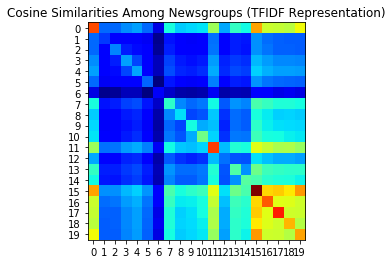

In [5]:
n_newsgroups = 20
training_set = fetch_20newsgroups()
token_model = CountVectorizer().fit_transform(training_set.data)
tfidf_model = TfidfTransformer().fit_transform(token_model)
score_map = [[-1 for i in range(n_newsgroups)] for j in range(n_newsgroups)]

#sort newsgroups using training set 
doc_partitions = [[] for x in range(n_newsgroups)]
for i in range(len(training_set.target)):
    tag = training_set.target[i]
    doc_partitions[tag].append(i)

#marginal unit vector sums for TFIDF 
doc_sums = marginal_unit_vector_sums(doc_partitions, tfidf_model)

for x in range(n_newsgroups):
    for y in range(n_newsgroups):
        iterations = len(doc_partitions[x]*len(doc_partitions[y]))
        #reduce number of calculations required by eliminating duplicates
        if score_map[y][x] != -1:
            score_map[x][y] = score_map[y][x]
        else:
            score_map[x][y] = dot(doc_sums[x], doc_sums[y])/iterations

# show matrix as heatmap

print ('Warmer colors in heatmap indicate higher cosine similarity: \n\n')
plt.title('Cosine Similarities Among Newsgroups (TFIDF Representation)')
plt.xticks(np.arange(0, 20, 1.0))
plt.yticks(np.arange(0, 20, 1.0))
plt.imshow(score_map, cmap='jet', interpolation='nearest')
plt.show()
plt.savefig('heatmap.png')

Next, some quick analysis of the newsgroup category names:

In [21]:
for i in range(20):
    print ('Newsgroup {} Category: {}'.format(i, training_set.target_names[i]))

Newsgroup 0 Category: alt.atheism
Newsgroup 1 Category: comp.graphics
Newsgroup 2 Category: comp.os.ms-windows.misc
Newsgroup 3 Category: comp.sys.ibm.pc.hardware
Newsgroup 4 Category: comp.sys.mac.hardware
Newsgroup 5 Category: comp.windows.x
Newsgroup 6 Category: misc.forsale
Newsgroup 7 Category: rec.autos
Newsgroup 8 Category: rec.motorcycles
Newsgroup 9 Category: rec.sport.baseball
Newsgroup 10 Category: rec.sport.hockey
Newsgroup 11 Category: sci.crypt
Newsgroup 12 Category: sci.electronics
Newsgroup 13 Category: sci.med
Newsgroup 14 Category: sci.space
Newsgroup 15 Category: soc.religion.christian
Newsgroup 16 Category: talk.politics.guns
Newsgroup 17 Category: talk.politics.mideast
Newsgroup 18 Category: talk.politics.misc
Newsgroup 19 Category: talk.religion.misc


According to the heatmap, the Atheism category appears to be very similar to the others (especially the last five categories regarding religion and politics), and the Miscellaneous "For Sale" category appears to be very different from the others. 

### 4.1: Setup

Now, we begin setting up the experiments. class0_pos refers to the directory which contains examples of the Atheism class, while class0_neg refers to the directory containing *all other documents.* The same structure applies to class6_pos and class6_neg.

In [22]:
class0_pos = "pos_0"
class0_neg = "neg_0"
class6_pos = "pos_6"
class6_neg = "neg_6"

count0_data = newsreader.DataManager(train_dir + class0_pos,
                                       train_dir + class0_neg,
                                       test_dir + class0_pos,
                                       test_dir + class0_neg,
                                       use_default_features(v),
                                       count_features,
                                       dev_dir + class0_pos if dev_dir else None,
                                       dev_dir if dev_dir else None,
                                       strip_metadata=has_bad_metadata)

count6_data = newsreader.DataManager(train_dir + class6_pos,
                                       train_dir + class6_neg,
                                       test_dir + class6_pos,
                                       test_dir + class6_neg,
                                       use_default_features(v),
                                       count_features,
                                       dev_dir + class6_pos if dev_dir else None,
                                       dev_dir if dev_dir else None,
                                       strip_metadata=has_bad_metadata)



count0_data.initialize(build_cache=True)
count6_data.initialize(build_cache=True)

Next, we create the boolean data representations (presence/absence features) of Newsgroup 0 and Newsgroup 6:

In [23]:
boolean_data_0 = newsreader.DataManager(train_dir + class0_pos,
                                         train_dir + class0_neg,
                                         test_dir + class0_pos,
                                         test_dir + class0_neg,
                                         use_default_features(v),
                                         make_boolean_features(count_features),
                                         dev_dir + class0_pos if dev_dir else None,
                                         dev_dir + class0_neg if dev_dir else None,
                                         strip_metadata=has_bad_metadata)

boolean_data_6 = newsreader.DataManager(train_dir + class6_pos,
                                         train_dir + class6_neg,
                                         test_dir + class6_pos,
                                         test_dir + class6_neg,
                                         use_default_features(v),
                                         make_boolean_features(count_features),
                                         dev_dir + class6_pos if dev_dir else None,
                                         dev_dir + class6_neg if dev_dir else None,
                                         strip_metadata=has_bad_metadata)


boolean_data_0.initialize(build_cache=True)
boolean_data_6.initialize(build_cache=True)

### 4.2 Initial experiments

#### 4.2.1: Experiment 10

Here, expt_10 is run for Newsgroup 0 classification and Newsgroup 6 classification. 

In [24]:
if selected("expt_10_c0"):
    expt_10_c0 = Experiment(count0_data,
                       "{}: {} vs {}, using word count features".format(all_data, class0_pos, class0_neg),
                       sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                       "logistic regression")
    expt_10_c0.initialize()
    expt_10_c0.xval()

Running xval
news/: pos_0 vs neg_0, using word count features
classified by logistic regression
average accuracy 0.6287974683544305 (std 0.020632814319877263)
[0.62658227848101267, 0.65822784810126578, 0.67088607594936711, 0.61392405063291144, 0.63291139240506333, 0.63291139240506333, 0.60126582278481011, 0.62658227848101267, 0.65189873417721522, 0.60126582278481011, 0.63924050632911389, 0.63291139240506333, 0.60126582278481011, 0.65189873417721522, 0.61392405063291144, 0.61392405063291144, 0.60126582278481011, 0.62658227848101267, 0.65822784810126578, 0.620253164556962],20


The accuracy for Class 0, as expected, is not very high; its documents are similar to various other documents.

In [25]:
if selected("expt_10_c6"):
    expt_10_c6 = Experiment(count6_data,
                       "{}: {} vs {}, using word count features".format(all_data, class6_pos, class6_neg),
                       sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                       "logistic regression")
    expt_10_c6.initialize()
    expt_10_c6.xval()

Running xval
news/: pos_6 vs neg_6, using word count features
classified by logistic regression
average accuracy 0.8528350515463918 (std 0.010992200057802127)
[0.87628865979381443, 0.83505154639175261, 0.86082474226804129, 0.865979381443299, 0.82989690721649489, 0.86082474226804129, 0.85051546391752575, 0.84536082474226804, 0.84536082474226804, 0.85567010309278346, 0.85567010309278346, 0.84536082474226804, 0.85567010309278346, 0.85051546391752575, 0.85051546391752575, 0.86082474226804129, 0.865979381443299, 0.84020618556701032, 0.86082474226804129, 0.84536082474226804],20


The classification for Class 6 is much more accurate, meaning that the model is better able to predict whether a document is in this class or not.

#### 4.2.2: Experiment 11

Now, we use boolean data for experiment 11:

In [26]:
if selected("expt_11_c0") :
    expt_11_c0 = Experiment(boolean_data_0,
                         "{}: {} vs {}, using word presence/absence features".format(all_data, class0_pos, class0_neg),
                         sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                         "logistic regression")
    expt_11_c0.initialize()
    expt_11_c0.xval()

Running xval
news/: pos_0 vs neg_0, using word presence/absence features
classified by logistic regression
average accuracy 0.5984177215189874 (std 0.005092872449187067)
[0.59493670886075944, 0.59493670886075944, 0.59493670886075944, 0.60126582278481011, 0.60759493670886078, 0.59493670886075944, 0.60759493670886078, 0.59493670886075944, 0.59493670886075944, 0.60126582278481011, 0.59493670886075944, 0.59493670886075944, 0.59493670886075944, 0.60759493670886078, 0.60126582278481011, 0.60126582278481011, 0.59493670886075944, 0.60126582278481011, 0.60126582278481011, 0.58860759493670889],20


Low classification accuracy--only 10% better than a blind guess--is evident for Class 0.

In [27]:
if selected("expt_11_c6") :
    expt_11_c6 = Experiment(boolean_data_6,
                         "{}: {} vs {}, using word presence/absence features".format(all_data, class6_pos, class6_neg),
                         sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                         "logistic regression")
    expt_11_c6.initialize()
    expt_11_c6.xval()

Running xval
news/: pos_6 vs neg_6, using word presence/absence features
classified by logistic regression
average accuracy 0.8409793814432991 (std 0.005473391902472997)
[0.84020618556701032, 0.83505154639175261, 0.84536082474226804, 0.83505154639175261, 0.84536082474226804, 0.84536082474226804, 0.84020618556701032, 0.83505154639175261, 0.84020618556701032, 0.84020618556701032, 0.84536082474226804, 0.83505154639175261, 0.85567010309278346, 0.84536082474226804, 0.83505154639175261, 0.84536082474226804, 0.84020618556701032, 0.83505154639175261, 0.83505154639175261, 0.84536082474226804],20


The accuracy for Class 6 classification using word presence/absence features is higher than that for Class 0, but lower than that of Class 6 using word count features.

### 4.3: Adding Weights

#### 4.3.1: IDF Weights

IDF weights are used with the word count feature representations of Class 0 and Class 6.

In [28]:
print ('\n CLASS 0:')

if selected("expt_10_20_c0") :
    expt_10_20_c0 = Experiment.transform(expt_10_c0,
                             idf_weights(expt_10_c0),
                             "features weighted by inverse document frequency",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_10_20_c0.xval()

print ('\n CLASS 6:')

if selected("expt_10_20_c6") :
    expt_10_20_c6 = Experiment.transform(expt_10_c6,
                             idf_weights(expt_10_c6),
                             "features weighted by inverse document frequency",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_10_20_c6.xval()


 CLASS 0:
Running xval
news/: pos_0 vs neg_0, using word count features
features weighted by inverse document frequency
classified by logistic regression
average accuracy 0.6325949367088608 (std 0.019037381319867135)
[0.63291139240506333, 0.67088607594936711, 0.62658227848101267, 0.63924050632911389, 0.63291139240506333, 0.59493670886075944, 0.60126582278481011, 0.65822784810126578, 0.63924050632911389, 0.62658227848101267, 0.60759493670886078, 0.62658227848101267, 0.63924050632911389, 0.63924050632911389, 0.63924050632911389, 0.620253164556962, 0.67088607594936711, 0.620253164556962, 0.63291139240506333, 0.63291139240506333],20

 CLASS 6:
Running xval
news/: pos_6 vs neg_6, using word count features
features weighted by inverse document frequency
classified by logistic regression
average accuracy 0.868814432989691 (std 0.021157580531433524)
[0.88659793814432986, 0.88144329896907214, 0.88659793814432986, 0.89690721649484539, 0.86082474226804129, 0.83505154639175261, 0.8762886597938144

#### 4.3.2: Wang-Manning Weights

Wang-Manning weights are added for the word presence/absence feature representations of Class 0 and Class 6.

In [29]:
print('CLASS 0:')

if selected("expt_11_20_c0") :
    expt_11_20_c0 = Experiment.transform(expt_11_c0,
                             wang_manning_weights(expt_11_c0),
                             "features weighted by evidence they give of class",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_11_20_c0.xval()

print('\n CLASS 6:')

if selected("expt_11_20_c6") :
    expt_11_20_c6 = Experiment.transform(expt_11_c6,
                             wang_manning_weights(expt_11_c6),
                             "features weighted by evidence they give of class",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                             "logistic regression")
    expt_11_20_c6.xval()

CLASS 0:
Running xval
news/: pos_0 vs neg_0, using word presence/absence features
features weighted by evidence they give of class
classified by logistic regression
average accuracy 0.5996835443037974 (std 0.009572457887502656)
[0.59493670886075944, 0.60126582278481011, 0.58860759493670889, 0.58860759493670889, 0.61392405063291144, 0.60759493670886078, 0.61392405063291144, 0.60126582278481011, 0.61392405063291144, 0.61392405063291144, 0.59493670886075944, 0.59493670886075944, 0.60126582278481011, 0.60759493670886078, 0.60126582278481011, 0.58860759493670889, 0.59493670886075944, 0.58227848101265822, 0.60126582278481011, 0.58860759493670889],20

 CLASS 6:
Running xval
news/: pos_6 vs neg_6, using word presence/absence features
features weighted by evidence they give of class
classified by logistic regression
average accuracy 0.8293814432989693 (std 0.012720580081704198)
[0.82474226804123707, 0.82989690721649489, 0.80412371134020622, 0.82474226804123707, 0.87113402061855671, 0.8092783505

### 4.4: Adding Word Embeddings

#### 4.4.1 Word Embeddings with Wang-Manning Weights

Here, we integrate word embeddings into experiments 11_20_c0 and 11_20_c6: 

In [30]:
print ('CLASS 0:')

if selected("expt_11_20_211_c0") :
    expt_11_20_211_c0 = Experiment.transform(expt_11_20_c0,
                             add_embeddings(expt_11_20_c0, e),
                             "enriched via word embeddings",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_20_211_c0.xval()

print ('\nCLASS 6:')

if selected("expt_11_20_211_c6") :
    expt_11_20_211_c6 = Experiment.transform(expt_11_20_c6,
                             add_embeddings(expt_11_20_c6, e),
                             "enriched via word embeddings",
                             sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       n_iter=50),
                            "logistic regression")
    expt_11_20_211_c6.xval()

CLASS 0:
Running xval
news/: pos_0 vs neg_0, using word presence/absence features
features weighted by evidence they give of class
enriched via word embeddings
classified by logistic regression
average accuracy 0.5971518987341773 (std 0.010642513747341927)
[0.58860759493670889, 0.60759493670886078, 0.60126582278481011, 0.59493670886075944, 0.58227848101265822, 0.58860759493670889, 0.58860759493670889, 0.59493670886075944, 0.60126582278481011, 0.59493670886075944, 0.58860759493670889, 0.57594936708860756, 0.58860759493670889, 0.60126582278481011, 0.60759493670886078, 0.620253164556962, 0.59493670886075944, 0.60126582278481011, 0.61392405063291144, 0.60759493670886078],20

CLASS 6:
Running xval
news/: pos_6 vs neg_6, using word presence/absence features
features weighted by evidence they give of class
enriched via word embeddings
classified by logistic regression
average accuracy 0.8229381443298971 (std 0.009681257717006678)
[0.83505154639175261, 0.81443298969072164, 0.82989690721649489,

### 4.5 : Analysis of Results and Conclusion

Interestingly, the individual patterns between the initial experiments in Part 1 are not consistent across the experiments in these new classification examples. For example, classification using word presence/absence features, Wang-Manning weights, and word embeddings combined was the most accurate in Part 1; however, here, the accuracy of this system was lower than that of the baseline experiments (10 and 11). This could be coincidental; it is likely that multiple iterations of these experiments need to be conducted, and the mean accuracies would present a better perspective on the effectiveness of each classification scheme. Significance tests would also need to be performed for a more in-depth analysis of these patterns.

However, regardless of this, the hypothesis of this experiment does hold true. Classification of Class 0, Atheism, was fairly low-accuracy, while the classification of Class 6, Misc: For Sale, was consistently better across all experiments. This is likely due to the fact that the first newsgroup has a high cosine similarity to the rest of the dataset, while the second has a lower cosine similarity and is therefore easier to distinguish.

A more in-depth analysis of the difference between the accuracies shows some interesting patterns (**NOTE: All calculations are based on the first iteration of these experiments; values may vary slightly)**:

- It appears that word embeddings do not make much of a difference; the accuracies of classification with Wang-Manning weights and the accuracies of classification with word embeddings and Wang-Manning weights combined are very similar for class 0 and identical for class 6.

- The average difference in accuracies between classification for class 0 and classification for class 6 across all 5 experiments was 23.09%. 

- The average accuracy for Class 0 classification was 61.01%.

- The average accuracy for Class 6 classification was 84.11%.

- The greatest difference in accuracy was for the second experiment, which used boolean features: 23.96%. 

- The least difference in accuracy was for the fourth experiment, which used Wang-Manning weights: 22.85%. However, the differences between other experiments were very similar to this number: 

    Exp 1 (word count features): 22.88%
    
    Exp 2 (boolean features): 23.96%
    
    Exp 3 (IDF weights): 22.81%
    
    Exp 4 (W-M weights): 22.85%
    
    Exp 5 (W-M weights + word embeddings w/ bool features): 22.98%

Now, we perform significance tests to evaluate the hypothesis: 


In [31]:
#statistical significance tests

expt_10_c0.initialize()
expt_10_c6.initialize()
expt_11_c0.initialize()
expt_11_c6.initialize()

EXPS = [[expt_10_c0.xval(), expt_11_c0.xval(), expt_10_20_c0.xval(), expt_11_20_c0.xval(), expt_11_20_211_c0.xval()],
        [expt_10_c6.xval(), expt_11_c6.xval(), expt_10_20_c6.xval(), expt_11_20_c6.xval(), expt_11_20_211_c6.xval()]]

#NUM_EXPS = len(EXPS)
#expt_num = 0

#for i in EXPS:
#    for x in range(len(i)):
#        accuracies[expt_num].append(i[x][0])
#    expt_num += 1

print(EXPS)

Running xval
news/: pos_0 vs neg_0, using word count features
classified by logistic regression
average accuracy 0.6231012658227848 (std 0.021876680927473885)
[0.60759493670886078, 0.61392405063291144, 0.620253164556962, 0.60759493670886078, 0.63291139240506333, 0.63291139240506333, 0.63924050632911389, 0.60759493670886078, 0.60759493670886078, 0.66455696202531644, 0.620253164556962, 0.620253164556962, 0.61392405063291144, 0.60126582278481011, 0.69620253164556967, 0.60759493670886078, 0.620253164556962, 0.61392405063291144, 0.620253164556962, 0.61392405063291144],20
Running xval
news/: pos_0 vs neg_0, using word presence/absence features
classified by logistic regression
average accuracy 0.6 (std 0.004292613913370446)
[0.60759493670886078, 0.59493670886075944, 0.59493670886075944, 0.60759493670886078, 0.59493670886075944, 0.60759493670886078, 0.60126582278481011, 0.60126582278481011, 0.59493670886075944, 0.60126582278481011, 0.60126582278481011, 0.60126582278481011, 0.60126582278481011

In [36]:
scipy.stats.ttest_ind(EXPS[0], EXPS[1], equal_var=True)

Ttest_indResult(statistic=-22.030840947732109, pvalue=1.9028563059438678e-08)

The t-test p-value (1.9 * 10^-8) indicates that the likelihood of such a high difference between the Class 0 classification accuracy and that of Class 6 classification is very unlikely to be coincidental. Thus, the differences between these accuracies can be considered truly significant, and the hypothesis that Class 6 will be more accurately identified than Class 0 is true. In other words, documents from a newsgroup with higher cosine similarity to the overall dataset are more difficult to identify, even when using several different experimental conditions.